In [0]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
spark = (SparkSession
.builder
.appName("ETL")
.getOrCreate()
)

In [0]:
from pyspark.sql.functions import col
from pyspark.sql.functions import avg
import matplotlib.pyplot as plt
import pandas
import seaborn as sns
from pyspark.sql.functions import concat, lit

In [0]:
flight_file_path = "dbfs:/FileStore/shared_uploads/nsingh17@stevens.edu/Airlines Airports Cancellation Codes & Flights/flights.csv"
airlines_file_path = "dbfs:/FileStore/shared_uploads/nsingh17@stevens.edu/Airlines Airports Cancellation Codes & Flights/airlines.csv"
airports_file_path = "dbfs:/FileStore/shared_uploads/nsingh17@stevens.edu/Airlines Airports Cancellation Codes & Flights/airports.csv"
cancelreason_file_path = "dbfs:/FileStore/shared_uploads/nsingh17@stevens.edu/Airlines Airports Cancellation Codes & Flights/cancellation_codes.csv"

In [0]:
cancelreason = spark.read.csv(cancelreason_file_path, header=True, inferSchema=True)
flights = spark.read.csv(flight_file_path, header=True, inferSchema=True)
airline_name = spark.read.csv(airlines_file_path, header=True, inferSchema=True)
airports = spark.read.csv(airports_file_path, header=True, inferSchema=True)

### Q1) How does the overall flight volumne vary by month? By day of week ?

+-----+------+
|MONTH| count|
+-----+------+
|    7|520718|
|    8|510536|
|    3|504312|
|    6|503897|
|    5|496993|
|   10|486165|
|    4|485151|
|   12|479230|
|    1|469968|
|   11|467972|
|    9|464946|
|    2|429191|
+-----+------+



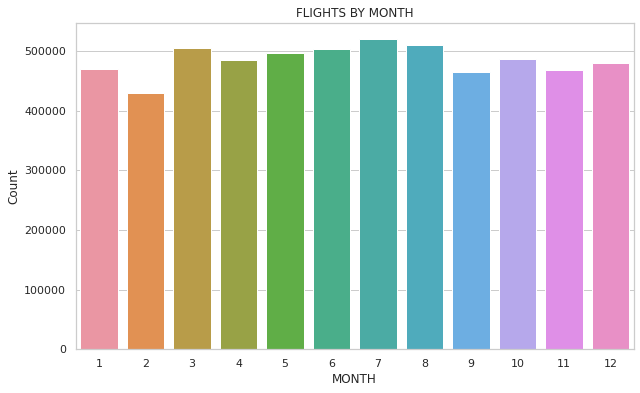

In [0]:
# Grouping on 'MONTH' column
q1 = flights.groupBy('MONTH').count()
q1.orderBy('count',ascending = False).show()
panda_df = q1.toPandas()
sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
sns.barplot(x='MONTH', y='count', data=panda_df)

# Set plot title and labels
plt.title('FLIGHTS BY MONTH')
plt.xlabel('MONTH')
plt.ylabel('Count')

plt.show()


Here first while doing grouping based on month, we can see that the month 7 which is July has the highest count when doing the analysis based on the month which comes down to 520718.
It can be concluded that the month of July was the busiest of all the year.



+-----------+------+
|DAY_OF_WEEK| count|
+-----------+------+
|          1|865543|
|          2|844600|
|          3|855897|
|          4|872521|
|          5|862209|
|          6|700545|
|          7|817764|
+-----------+------+



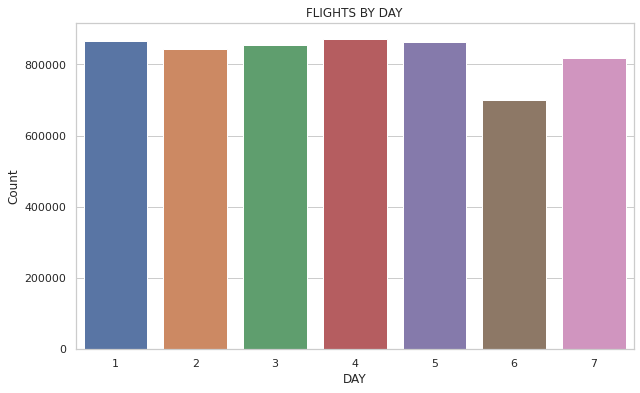

In [0]:
#Grouping on 'DAY_of_WEEK' column
q1_1 = flights.groupBy('DAY_OF_WEEK').count()
q1_1.orderBy('DAY_OF_WEEK').show()

pandas_df = q1_1.toPandas()
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.barplot(x='DAY_OF_WEEK', y='count', data=pandas_df)
    
# Set plot title and labels
plt.title('FLIGHTS BY DAY')
plt.xlabel('DAY')
plt.ylabel('Count')

plt.show()

Now doing the grouping based on DAY_OF_WEEK  and plotting a bar plot and based on the count we can infer that the busiest day of the week comes to be the very first day itself.


In [0]:
spark = (SparkSession
.builder
.appName("canceled and its percentage")
.getOrCreate()
)

###Q2) How many flights were canceled and its percentage ?

In [0]:
cancelreason = cancelreason.withColumnRenamed('CANCELLATION_REASON','CANCEL_REASON')

cancel_df = flights.select('AIRLINE','CANCELLATION_REASON','CANCELLED').where(flights['CANCELLED']==1)
cancel_df = cancel_df.withColumnRenamed('AIRLINE','AIRLINE_ABB')

joined_df = cancel_df.join(airline_name, cancel_df["AIRLINE_ABB"] == airline_name["IATA_CODE"])

group_df = cancel_df.groupBy('AIRLINE_ABB').sum('CANCELLED')
# group_df = group_df.orderBy('sum(CANCELLED)',ascending = False)
jdf = group_df.join(airline_name,group_df['AIRLINE_ABB'] == airline_name['IATA_CODE'])
jdf = jdf.drop('IATA_CODE')
jdf = jdf.orderBy('sum(CANCELLED)', ascending = False)

joined_df1 = joined_df.join(cancelreason,cancelreason["CANCEL_REASON"] == joined_df["CANCELLATION_REASON"])

joined_df1 = joined_df1.drop('IATA_CODE','CANCEL_REASON','AIRLINE_ABB')


# how many percent of the flights are cancelled?
Total_flights_cancelled = cancel_df.count()
Total_flights = flights.count()
percentage = Total_flights_cancelled*100/Total_flights
print("% = ",percentage)

# how many flights were cancelled ?
Total_flights_cancelled = cancel_df.count()
print("Total flights cancelled = ",Total_flights_cancelled)

% =  1.5446430612129514
Total flights cancelled =  89884



In the dataset analyzed, there were 89,884 flights canceled, which represents approximately 1.54% of the total flights. This indicates a notable but not overwhelming percentage of cancellations within the dataset. 

In [0]:
spark = (SparkSession
.builder
.appName("cancellation of each reason")
.getOrCreate()
)

###Q3) Primary cause of cancellation, and percentage of cancellation of each reason?

Factors contributing to flight cancellations could include weather conditions, mechanical issues, air traffic control delays, scheduling adjustments from airline/carrier or security.
Understanding the reasons behind these cancellations could help airlines improve their operations and minimize disruptions for passengers.
The reasons will be analyzed in this question.


In [0]:
# total flights cancelled due to weather?
Total_flights_cancelled_weather = cancel_df.where(cancel_df['CANCELLATION_REASON'] == 'B')
Total_flights_cancelled_weather = Total_flights_cancelled_weather.count()

# total flights cancelled due to airline/carrier?
Total_flights_cancelled_airline = cancel_df.where(cancel_df['CANCELLATION_REASON'] == 'A')
Total_flights_cancelled_airline = Total_flights_cancelled_airline.count()

# total flights cancelled due to national air system?
Total_flights_cancelled_nsa = cancel_df.where(cancel_df['CANCELLATION_REASON'] == 'C')
Total_flights_cancelled_nsa = Total_flights_cancelled_nsa.count()

# total flights cancelled due to security?
Total_flights_cancelled_sec = cancel_df.where(cancel_df['CANCELLATION_REASON'] == 'D')
Total_flights_cancelled_sec = Total_flights_cancelled_sec.count()

# Total flights cancelled based on their reasons.
# Primary Cause of cacellation
cancelreason = cancelreason.withColumn('Total Cancelled', F.when(cancelreason['CANCEL_REASON'] == 'A',Total_flights_cancelled_airline)
                                                               .when(cancelreason['CANCEL_REASON'] == 'B',Total_flights_cancelled_weather)
                                                                     .when(cancelreason['CANCEL_REASON'] == 'C',Total_flights_cancelled_nsa)
                                                                           .when(cancelreason['CANCEL_REASON'] == 'D',Total_flights_cancelled_sec))
cancelreason.orderBy('Total Cancelled', ascending = True)
cancelreason.show()

cancelreason.groupBy().sum('Total Cancelled')

#percent of each cancellation attribute

percent_flight_cancelled_weather = Total_flights_cancelled_weather*100/Total_flights_cancelled
print("can% weather =",percent_flight_cancelled_weather)

percent_flight_cancelled_airline = Total_flights_cancelled_airline*100/Total_flights_cancelled
print("can% airline =",percent_flight_cancelled_airline)

percent_flight_cancelled_sec = Total_flights_cancelled_sec*100/Total_flights_cancelled
print("can% security =",percent_flight_cancelled_sec)

percent_flight_cancelled_nsa = Total_flights_cancelled_nsa*100/Total_flights_cancelled
print("can% national air system=",percent_flight_cancelled_nsa)

+-------------+------------------------+---------------+
|CANCEL_REASON|CANCELLATION_DESCRIPTION|Total Cancelled|
+-------------+------------------------+---------------+
|            A|         Airline/Carrier|          25262|
|            B|                 Weather|          48851|
|            C|     National Air System|          15749|
|            D|                Security|             22|
+-------------+------------------------+---------------+

can% weather = 54.348938632014594
can% airline = 28.105113257086913
can% security = 0.024475991277646745
can% national air system= 17.521472119620846


 The primary causes of flight cancellations in the dataset were weather-related issues, accounting for approximately 54.35% of all cancellations, and airline or carrier-related issues, making up around 28.11% of cancellations. National Air System issues contributed to approximately 17.52% of cancellations, while security concerns were responsible for an extremely small percentage, just 0.02%. 


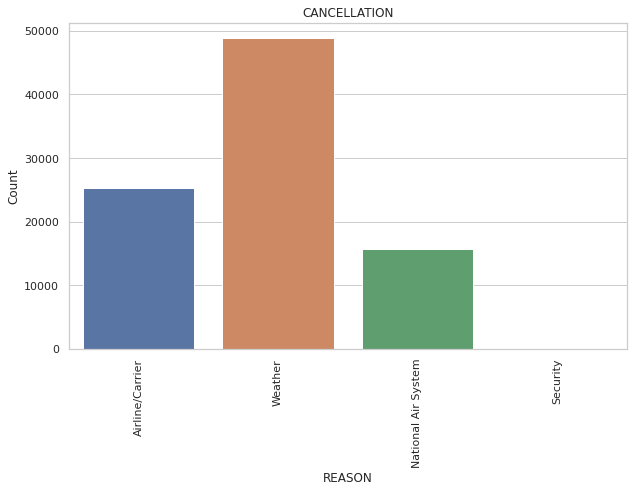

In [0]:
pandas_df = cancelreason.toPandas()
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.barplot(x='CANCELLATION_DESCRIPTION', y='Total Cancelled', data=pandas_df)

# Set plot title and labels
plt.title('CANCELLATION')
plt.xlabel('REASON')
plt.ylabel('Count')
plt.xticks(rotation=90)

plt.show()

Weather-related cancellations appear to be the most prevalent, indicating the significant impact of weather conditions on flight operations.

In [0]:
spark = (SparkSession
.builder
.appName("experienced a departure delay")
.getOrCreate()
)

### Q4)What percentage of flights in experienced a departure delay? Among those flights, what was the average delay time, in minutes?

First we considered only the delayed flights and flights which were not cancelled


In [0]:
q4 = flights.select('AIRLINE','MONTH','DEPARTURE_DELAY').where(flights['CANCELLED'] == 0)
q4 = q4.where((q4['DEPARTURE_DELAY'] > 0))
q4.show()

+-------+-----+---------------+
|AIRLINE|MONTH|DEPARTURE_DELAY|
+-------+-----+---------------+
|     US|    1|             14|
|     DL|    1|              3|
|     NK|    1|             25|
|     NK|    1|             12|
|     AA|    1|             21|
|     NK|    1|             72|
|     UA|    1|              3|
|     B6|    1|             95|
|     B6|    1|              4|
|     B6|    1|             72|
|     OO|    1|             13|
|     UA|    1|              4|
|     AA|    1|            108|
|     EV|    1|              2|
|     US|    1|             60|
|     AA|    1|             58|
|     OO|    1|              5|
|     UA|    1|              2|
|     UA|    1|              4|
|     AA|    1|             53|
+-------+-----+---------------+
only showing top 20 rows



In [0]:
#joining the data set to get the full airline name

airline_name = airline_name.withColumnRenamed("AIRLINE","NAME")

df = q4.join(airline_name, q4["AIRLINE"] == airline_name["IATA_CODE"])
df.drop('IATA_CODE')
df = df.select('NAME','AIRLINE','MONTH','DEPARTURE_DELAY')
df.show()


+--------------------+-------+-----+---------------+
|                NAME|AIRLINE|MONTH|DEPARTURE_DELAY|
+--------------------+-------+-----+---------------+
|     US Airways Inc.|     US|    1|             14|
|Delta Air Lines Inc.|     DL|    1|              3|
|    Spirit Air Lines|     NK|    1|             25|
|    Spirit Air Lines|     NK|    1|             12|
|American Airlines...|     AA|    1|             21|
|    Spirit Air Lines|     NK|    1|             72|
|United Air Lines ...|     UA|    1|              3|
|     JetBlue Airways|     B6|    1|             95|
|     JetBlue Airways|     B6|    1|              4|
|     JetBlue Airways|     B6|    1|             72|
|Skywest Airlines ...|     OO|    1|             13|
|United Air Lines ...|     UA|    1|              4|
|American Airlines...|     AA|    1|            108|
|Atlantic Southeas...|     EV|    1|              2|
|     US Airways Inc.|     US|    1|             60|
|American Airlines...|     AA|    1|          

In [0]:
delay = df.groupBy('NAME').count()
delay = delay.orderBy('count')
delay.show()

+--------------------+------+
|                NAME| count|
+--------------------+------+
|Hawaiian Airlines...| 20140|
|      Virgin America| 23366|
|Frontier Airlines...| 34859|
|Alaska Airlines Inc.| 43541|
|    Spirit Air Lines| 52033|
|     US Airways Inc.| 62452|
|American Eagle Ai...| 93232|
|     JetBlue Airways|102012|
|Atlantic Southeas...|169503|
|Skywest Airlines ...|171181|
|American Airlines...|245550|
|United Air Lines ...|256241|
|Delta Air Lines Inc.|282385|
|Southwest Airline...|566583|
+--------------------+------+



Displaying the number of delayed flights for each airline, with Southwest Airlines having the highest count (566,583) and Hawaiian Airlines the lowest (20,140).
Plotting  a barplot for the same below

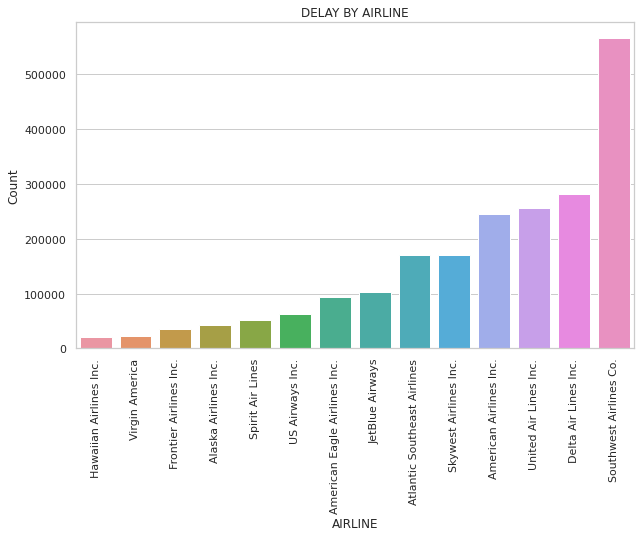

In [0]:
pandas_df = delay.toPandas()
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.barplot(x='NAME', y='count', data=pandas_df)
# Set plot title and labels
plt.title('DELAY BY AIRLINE')
plt.xlabel('AIRLINE')
plt.ylabel('Count')
plt.xticks(rotation=90)

plt.show()

Now here we used the total number of flights which were not cancelled.

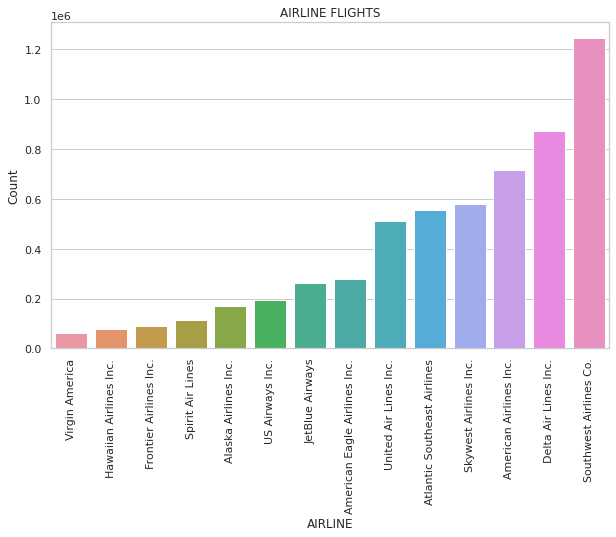

In [0]:
df= flights.select('AIRLINE').where(flights['CANCELLED'] == 0)
df1 = df.join(airline_name, df["AIRLINE"] == airline_name["IATA_CODE"])
df1.drop('IATA_CODE')


grp = df1.groupBy('NAME').count()
grp = grp.orderBy('count')


pandas_df = grp.toPandas()
sns.set(style="whitegrid")



plt.figure(figsize=(10, 6))
sns.barplot(x='NAME', y='count', data=pandas_df)
plt.title('AIRLINE FLIGHTS')
plt.xlabel('AIRLINE')
plt.ylabel('Count')
plt.xticks(rotation=90)

plt.show()

In [0]:
grp = grp.withColumnRenamed('count','Total_Flights')
delay = delay.withColumnRenamed('count','Delay_flights')
delay = delay.withColumnRenamed('NAME','N')
# Join the 'grp' DataFrame (total flights) with the 'delay' DataFrame (delayed flights) on the airline name
inference = grp.join(delay, grp['NAME']==delay['N'])

# Calculate the percentage of non-delayed flights and add it as a new column 'Percentage_delay'
inference = inference.withColumn('Percentage_delay', ((inference['Total_Flights'] - inference['Delay_flights']) /inference['Total_Flights'])*100)

inference = inference.select('NAME','Total_Flights','Delay_flights','Percentage_delay')
inference.orderBy('Percentage_delay',ascending = False).show()

+--------------------+-------------+-------------+------------------+
|                NAME|Total_Flights|Delay_flights|  Percentage_delay|
+--------------------+-------------+-------------+------------------+
|Alaska Airlines Inc.|       171852|        43541|  74.6636640830482|
|Hawaiian Airlines...|        76101|        20140| 73.53517036569822|
|Skywest Airlines ...|       578393|       171181| 70.40403324383247|
|Atlantic Southeas...|       556746|       169503| 69.55469819271266|
|     US Airways Inc.|       194648|        62452| 67.91541654679216|
|Delta Air Lines Inc.|       872057|       282385| 67.61851576215776|
|American Eagle Ai...|       279607|        93232| 66.65605653649587|
|American Airlines...|       715065|       245550| 65.66046443330326|
|      Virgin America|        61369|        23366|61.925402075966694|
|Frontier Airlines...|        90248|        34859| 61.37421327896463|
|     JetBlue Airways|       262772|       102012| 61.17851217024645|
|    Spirit Air Line

After taking into consideration the total number of flights and taking the delay as percentage we get Alaska airlines as the airline with highest delay while United Air Lines with the lowest.

In previous graph Southwest was highest because the total no, of flights of the airline was also the highest.
Therefore, percentage helps us get a clearer picture.


In [0]:
spark = (SparkSession
.builder
.appName("routes are typically most delayed")
.getOrCreate()
)

###Q5) Which routes are typically most delayed ?

The flights DataFrame is filtered to select flights that experienced delays at both departure and arrival. The selected columns are MONTH, AIRLINE, ORIGIN_AIRPORT, DESTINATION_AIRPORT, and ARRIVAL_DELAY

In [0]:
flights_delayed = flights.select('MONTH','AIRLINE','ORIGIN_AIRPORT','DESTINATION_AIRPORT','ARRIVAL_DELAY').where((flights['ARRIVAL_DELAY']>0) & (flights['DEPARTURE_DELAY']>0))
#Filter data 
airports_ond = flights_delayed.groupBy('MONTH','ORIGIN_AIRPORT','DESTINATION_AIRPORT').avg('ARRIVAL_DELAY')
airports_ond.orderBy('avg(ARRIVAL_DELAY)',ascending = False).show(4)

+-----+--------------+-------------------+------------------+
|MONTH|ORIGIN_AIRPORT|DESTINATION_AIRPORT|avg(ARRIVAL_DELAY)|
+-----+--------------+-------------------+------------------+
|    2|           BZN|                ATL|            1107.0|
|    2|           VEL|                SLC|             623.0|
|    5|           LNK|                ATL|             553.0|
|    3|           JFK|                HNL|             527.5|
+-----+--------------+-------------------+------------------+
only showing top 4 rows



The output shows the top 4 airport pairs (origin and destination) with the highest average arrival delays, along with the month in which these delays occurred.

In [0]:
spark = (SparkSession
.builder
.appName("most & least reliable")
.getOrCreate()
)

###Q6) Which airline seems to be most & least reliable ?

Reliability percentages are calculated based on the proportion of flights that are delayed and cancelled out of the total number of flights operated by each airline.We derived and used the formula to calculate the same .Higher reliability percentages indicate a lower incidence of delays and cancellations, while lower percentages indicate a higher incidence of disruptions.


Two datasets, inference and jdf, were used in the analysis. These datasets were joined on the airline name (NAME in inference and AIRLINE in jdf) to consolidate the relevant information.

In [0]:
reliable = inference.join(jdf, inference["NAME"] == jdf["AIRLINE"])
reliable = reliable.withColumnRenamed('sum(CANCELLED)','Cancelled_flights')
reliable = reliable.withColumn('Percentage_cancelled', ((reliable['Cancelled_flights']) /reliable['Total_Flights'])*100)
reliable = reliable.select('AIRLINE','Total_Flights','Delay_flights','Percentage_delay','Cancelled_flights','Percentage_cancelled')

#This formula determines the proportion of flights that were neither delayed nor cancelled, thus providing a measure of the airline's reliability.
reliability = reliable.withColumn('RELIABILITY_PERCENTAGE', ((reliable['Total_Flights'] - ((reliable['Delay_flights'] + reliable['Cancelled_flights'])))/reliable['Total_Flights'])*100)

reliability = reliability.orderBy('RELIABILITY_PERCENTAGE',ascending = False)
reliability.show()

+--------------------+-------------+-------------+------------------+-----------------+--------------------+----------------------+
|             AIRLINE|Total_Flights|Delay_flights|  Percentage_delay|Cancelled_flights|Percentage_cancelled|RELIABILITY_PERCENTAGE|
+--------------------+-------------+-------------+------------------+-----------------+--------------------+----------------------+
|Alaska Airlines Inc.|       171852|        43541|  74.6636640830482|              669|  0.3892884575099504|     74.27437562553826|
|Hawaiian Airlines...|        76101|        20140| 73.53517036569822|              171| 0.22470138368746798|     73.31046898201075|
|Skywest Airlines ...|       578393|       171181| 70.40403324383247|             9960|  1.7220125416455594|     68.68202070218692|
|Delta Air Lines Inc.|       872057|       282385| 67.61851576215776|             3824|   0.438503446449028|     67.18001231570872|
|Atlantic Southeas...|       556746|       169503| 69.55469819271266|       

Most Reliable Airline: Alaska Airlines Inc. appears to be the most reliable airline, with a reliability percentage of approximately 74.27%. This indicates that the majority of their flights operate without significant delays or cancellations.
Least Reliable Airline: United Air Lines Inc. seems to be the least reliable airline among those listed, with a reliability percentage of around 48.38%. This suggests that a significant portion of their flights experience delays or cancellations.


In [0]:
spark = (SparkSession
.builder
.appName("do well for the same routes")
.getOrCreate()
)

###Q7) What are the alternate airlines that do well for the same routes ?

In [0]:
data = flights.select('MONTH','AIRLINE','ORIGIN_AIRPORT','DESTINATION_AIRPORT','ARRIVAL_DELAY').where(flights['ARRIVAL_DELAY'] <=0)

grpp = data.groupBy('AIRLINE','ORIGIN_AIRPORT','DESTINATION_AIRPORT').agg(F.sum('ARRIVAL_DELAY').alias('TOTAL_DELAY'))
grpp = grpp.orderBy('TOTAL_DELAY',ascending = True)
grpp.show()

+-------+--------------+-------------------+-----------+
|AIRLINE|ORIGIN_AIRPORT|DESTINATION_AIRPORT|TOTAL_DELAY|
+-------+--------------+-------------------+-----------+
|     DL|           LGA|                ATL|     -68931|
|     AA|           LGA|                ORD|     -60578|
|     AA|           ORD|                DFW|     -59680|
|     AA|           JFK|                LAX|     -58411|
|     AA|           LGA|                DFW|     -57198|
|     AA|           LAX|                JFK|     -54137|
|     DL|           MCO|                ATL|     -54002|
|     DL|           FLL|                ATL|     -52774|
|     AA|           DFW|                ORD|     -51655|
|     DL|           EWR|                ATL|     -49296|
|     AA|           LGA|                MIA|     -47330|
|     AA|           DFW|                LAX|     -46272|
|     UA|           LGA|                ORD|     -46259|
|     DL|           PHL|                ATL|     -45797|
|     DL|           DCA|       

In [0]:
# Combining the two string columns into one
grpp = grpp.withColumn("ROUTE", concat(grpp["ORIGIN_AIRPORT"], lit("-"), grpp["DESTINATION_AIRPORT"]))
grpp = grpp.drop('ORIGIN_AIRPORT','DESTINATION_AIRPORT')
grpp = grpp.select('AIRLINE','ROUTE','TOTAL_DELAY')
# Showing the DataFrame with the combined column
grpp.show()

+-------+-------+-----------+
|AIRLINE|  ROUTE|TOTAL_DELAY|
+-------+-------+-----------+
|     DL|LGA-ATL|     -68931|
|     AA|LGA-ORD|     -60578|
|     AA|ORD-DFW|     -59680|
|     AA|JFK-LAX|     -58411|
|     AA|LGA-DFW|     -57198|
|     AA|LAX-JFK|     -54137|
|     DL|MCO-ATL|     -54002|
|     DL|FLL-ATL|     -52774|
|     AA|DFW-ORD|     -51655|
|     DL|EWR-ATL|     -49296|
|     AA|LGA-MIA|     -47330|
|     AA|DFW-LAX|     -46272|
|     UA|LGA-ORD|     -46259|
|     DL|PHL-ATL|     -45797|
|     DL|DCA-ATL|     -44999|
|     UA|EWR-SFO|     -43713|
|     AA|LAX-DFW|     -42696|
|     UA|LAX-EWR|     -42278|
|     DL|ATL-LGA|     -41148|
|     AA|SAT-DFW|     -41126|
+-------+-------+-----------+
only showing top 20 rows



In [0]:
route_list = ['BZN-ATL', 'VEL-SLC', 'LNK-ATL', 'JFK-HNL']


# Filter DataFrame based on the two lists with order matters
filtered_df = grpp.filter((col("ROUTE").isin(route_list)))

# Showing the result DataFrame
filtered_df.show()

+-------+-------+-----------+
|AIRLINE|  ROUTE|TOTAL_DELAY|
+-------+-------+-----------+
|     EV|LNK-ATL|      -3093|
|     OO|VEL-SLC|      -2911|
|     HA|JFK-HNL|      -2087|
|     DL|BZN-ATL|      -1235|
|     DL|JFK-HNL|       -471|
+-------+-------+-----------+



These alternate airlines demonstrate better performance in terms of timeliness on the specified routes, which are the most delayed routes calculated in the previous question and consistently arriving earlier than scheduled or with minimal delays compared to other carriers.